# Code Original



In [2]:
import tensorflow as tf
import numpy as np

class TBHCNN():
    """
    Tight-binding Hamiltonian construction neural network
    """
    def __init__(self):
        """
        initialize TBHCNN class
        """
        super(TBHCNN, self).__init__()
        self.H_size_added = 0
        
    def read_training_set(self, references, kvectors):
        """
        read ab-inirio reference band data (energies and k-vectors)
        
        numk: number of the k points per referebce band
        numb: number of the reference bands
        
        Parameters
        ----------

        references: Variable(np.array) shape (numk, numb)
          energy bands to be fitted
        kvectors: Variable(np.array) shape (numk, 3)
          k vectors of the band data
        """
        
        numk, numb = references.shape
        
        self.numb = numb
        self.numk = numk
        self.H_size_init = numb
        self.H_size = numb
        self.references = tf.constant(references, tf.float64)
        self.K = tf.constant(kvectors, tf.complex64)
    
    def define_TB_representation(self, rvectors_without_opposite):
        """
        define the TB model desired by selecting the considered lattice vectors
        
        numr: number of the real-space Hamiltonians desired to be include 
        in the TB model in practice 
        
        Parameters
        ----------
        rvectors_without_opposite: Variable(int np.array) shape ((numr+1)/2, 3)
          lattice vectors of the real-space Hamiltonians without the opposite 
          vectores appearing at the same time.
          
        """
        len_rvector = rvectors_without_opposite.shape[0]
        numr = 2 * len_rvector - 1
        self.R = np.array([])
        
        for i in rvectors_without_opposite:
            self.R = np.append(self.R, i)
            if np.sum(np.abs(i)) != 0:
                self.R = np.append(self.R, -1*i)
                
        self.numr = numr        
        self.R = self.R.reshape(-1,3)
        self.R = tf.cast(self.R, tf.complex64)
        self.R_without_opposite = rvectors_without_opposite

    def reinitialize(self):
        """
        initialize/reinitialize the real-space Hamiltonian matrices
    
        """
        self.HR = []
        self.H_size = self.H_size_init + self.H_size_added
        
        for i in self.R_without_opposite:
            H_tmp = tf.cast(tf.Variable(tf.truncated_normal([self.H_size, self.H_size], mean=0.0, stddev=1.0,dtype=tf.float64)), dtype=tf.complex64)
            
            # Once we take into consideration the real-space Hamiltonian H(R=Ri), 
            # we must consider H(R=-Ri) also, which is the tranposed matrix of 
            # H(R=Ri), to ensure that calculated reciprocal-space Hamiltonian maintains Hermitian
            if np.sum(np.abs(i)) != 0:
                self.HR.append(H_tmp)
                self.HR.append(tf.transpose(H_tmp))
            else:
                self.HR.append(H_tmp + tf.transpose(H_tmp)) #ensure that H(R=[0,0,0]) maintains symmetric  
                
        self.HR = tf.cast(self.HR, tf.complex64)
                
    def compute_bands(self):
        """
        Using the real-space Hamiltonians considered to compute the k-space 
        Hamiltonians to compute the energy bands
        
        """
        reproduces = tf.zeros([self.numk,self.H_size], dtype=tf.float64)
        for i in range(self.numk):
            HK = tf.zeros([self.H_size, self.H_size], dtype = tf.complex64)
            for j in range(self.numr):
                HK += tf.scalar_mul(tf.exp(1j*tf.reduce_sum(self.K[i]*self.R[j])),self.HR[j])
                
            e = tf.self_adjoint_eigvals(HK)
            e = tf.cast(e, tf.float64)
            e = tf.reshape(e,[1,self.H_size])
            reproduces = reproduces + tf.scatter_nd([[i]], e, [self.numk,self.H_size])
         
        self.wholebandstructure = reproduces
        
        # the added bands will be placed above and/or below the references, 
        # and they will not be used for loss function computation
        reproduces = reproduces[:, int(self.H_size_added/2):int(self.H_size_added//2)+self.numb]
         
        self.reproduces = reproduces
        
        return reproduces


In [3]:


# we take the example of the 13-atom-wide InSe

# Define the tight-binding representation by selecting the real-space Hamiltonian considered
"""
Here, to ensure that the Hamiltonians with the opposite lattice vectors are always taken into consideration simultaneously, and they tranpose each other
only one of each pair of the opposite lattice vectors should be included in the rvectors array, the other one will be handled automatically
e.g., for this system, both np.array([[0,0,0],[0,0,1],]) and np.array([[0,0,0],[0,0,-1],]) represent the lattice vector set np.array([[0,0,0],[0,0,1],[0,0,-1]])
and in the end we shall get the 3 real-space Hamiltonian matrices we actually used to build the tight-binding model
"""
rvectors_without_opposite = np.array([[0,0,0],[0,0,1],], dtype=np.int32) # in units of[a, b, c] (a, b, and c are the real-space basis vectors; [l, n, m] means the lattice vector l*a+n*b+m*c)

# Energy bands data as references 
references = np.load("./data/input/InSe Nanoribbon/InSe-references.npy")
kvectors = np.load("./data/input/InSe Nanoribbon/InSe-kpoints.npy") # in units of 1/2pi*[ak, bk, ck] (ak, bk, and ck are the corresponding k-space basis vectors; [l, n, m] means the k-vector (l/2pi)*ak+(n/2pi)*bk+(m/2pi)*ck)

# Hyperparameters
Optimizer = tf.train.AdamOptimizer(0.001)
threshold = 1e-5
max_training_steps = 10000
basis_added_step = 2

sess = tf.Session()

def fitting(Optimizer, loss_threshold, max_train_steps, tbhcnn):
    reproduces = tbhcnn.compute_bands() 
    loss = tf.reduce_mean(tf.square(reproduces-tbhcnn.references))
    train = Optimizer.minimize(loss)
    init = tf.global_variables_initializer()
    sess.run (init)
    train_steps = 0
    print("initial loss value: %.8f" % (sess.run(loss)))
    while (sess.run(loss)>loss_threshold) and (train_steps < max_train_steps):
        sess.run(train)
        train_steps += 1
        if train_steps%1000 == 0:
            print("steps:%s, loss:%.8f" % (train_steps, sess.run(loss)))
    if sess.run(loss)>loss_threshold:
        return False
    else:
        return tbhcnn.HR
     
def main():
    tbhcnn = TBHCNN()
    tbhcnn.read_training_set(references, kvectors)
    tbhcnn.define_TB_representation(rvectors_without_opposite)
    tbhcnn.reinitialize()
    
    finished = fitting(Optimizer, threshold , max_training_steps, tbhcnn)
    
    while finished == False:
        tbhcnn.H_size_added += basis_added_step
        tbhcnn.reinitialize()
        finished = fitting(Optimizer, threshold , max_training_steps, tbhcnn)
        
    # output the trained real-space Hamiltonians, their corresponding lattice vectors, their computed 
    # bandstructure, and their reproduction of the reference bands
    
    Resulting_Hamiltonian = sess.run(tf.cast(finished, tf.float64))
    Rvectors_of_the_resulting_hamiltonian = sess.run(tf.cast(tbhcnn.R, tf.int32))
    Reproduced_TB_bandstructure = sess.run(tbhcnn.wholebandstructure)
    Reproduced_TB_bands = sess.run(tbhcnn.reproduces)
            
    
    
    print("final loss value: %.8f" % sess.run(tf.reduce_mean(tf.square(tbhcnn.reproduces-tbhcnn.references))))

    sess.close()
    return(Reproduced_TB_bands)
    
reproduced_band=main()






initial loss value: 31.67921122
steps:1000, loss:2.04220254
steps:2000, loss:0.06688630
steps:3000, loss:0.00122940
steps:4000, loss:0.00035094
steps:5000, loss:0.00031500
steps:6000, loss:0.00030704
steps:7000, loss:0.00030428
steps:8000, loss:0.00030278
steps:9000, loss:0.00030199
steps:10000, loss:0.00030154
initial loss value: 27.82357798
steps:1000, loss:0.70299957
steps:2000, loss:0.01062030
steps:3000, loss:0.00084632
steps:4000, loss:0.00021069
steps:5000, loss:0.00006447
steps:6000, loss:0.00003222
steps:7000, loss:0.00002463
steps:8000, loss:0.00002127
steps:9000, loss:0.00001791
steps:10000, loss:0.00001462
initial loss value: 23.81081009
steps:1000, loss:0.31979998
steps:2000, loss:0.00830411
steps:3000, loss:0.00087184
steps:4000, loss:0.00017870
steps:5000, loss:0.00007243
steps:6000, loss:0.00004223
steps:7000, loss:0.00002665
steps:8000, loss:0.00001752
steps:9000, loss:0.00001254
steps:10000, loss:0.00001015
initial loss value: 18.44564827
steps:1000, loss:0.13470

In [9]:
print(reproduced_band)

[[-0.66455859 -0.46190172 -0.28366736 -0.15918535 -0.13378428 -0.09340224
  -0.09144198  1.46935046  1.87412632  2.14958811  2.25009179  2.31219006
   2.4145503   2.45107484]
 [-0.66486686 -0.46467128 -0.2832725  -0.1575788  -0.13440174 -0.0933181
  -0.09186029  1.47260261  1.87711942  2.15158892  2.2493813   2.30991793
   2.41496301  2.45206881]
 [-0.66689134 -0.46882081 -0.28392267 -0.15820305 -0.13302819 -0.094667
  -0.09176148  1.48439276  1.88428736  2.15576792  2.24877     2.30628633
   2.41583681  2.45390987]
 [-0.67170256 -0.46992174 -0.28877965 -0.16324781 -0.12961195 -0.09677626
  -0.09237323  1.50772178  1.89320529  2.15954494  2.25043654  2.30618739
   2.41693568  2.4553113 ]
 [-0.67795062 -0.47264138 -0.29716641 -0.16821551 -0.12781733 -0.09876808
  -0.09413187  1.54179549  1.9056108   2.16397166  2.25348926  2.30951142
   2.41921306  2.45720863]
 [-0.68444663 -0.48449898 -0.30434945 -0.17368023 -0.12599334 -0.10113395
  -0.09521435  1.58258748  1.92644227  2.17153192  2.2

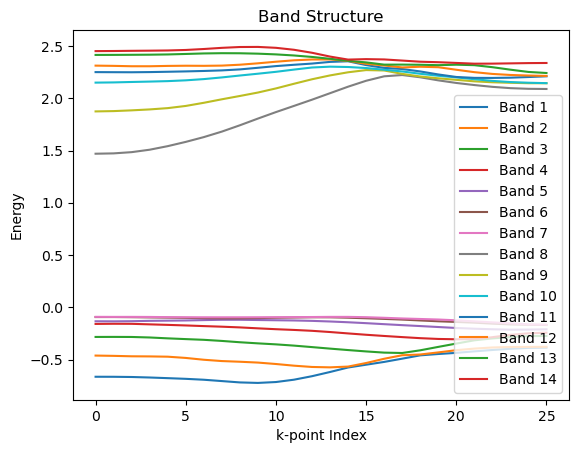

In [10]:
import matplotlib.pyplot as plt

# Assuming the horizontal axis is the band index and the vertical axis is the energy
for band in range(reproduced_band.shape[1]):
    plt.plot(reproduced_band[:, band], label=f'Band {band+1}')

plt.xlabel('k-point Index')
plt.ylabel('Energy')
plt.title('Band Structure')
plt.legend()
plt.show()